In [2]:
import pandas as pd
from collections import Counter
import numpy as nm
import matplotlib.pyplot as plt
import warnings
import random
import datetime
warnings.filterwarnings("ignore")
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
import cv2 as cv2
import os
import math as m
  

## Negative comments identification
### File Loading & Text Preprocessing

In [3]:
'''
data= pd.read_json("review.json", lines=True, chunksize=100000)
i=1
for c in data:
    c.to_csv("review"+str(i)+".csv", index=False)
    i=i+1
'''   

'\ni=1\nfor c in data:\n    c.to_csv("review"+str(i)+".csv", index=False)\n    i=i+1\n'

In [3]:
def prepareData(number):
    df= pd.DataFrame(columns=["stars", 'text'])
    for c in range(1,number):#67
        m=pd.read_csv("review"+str(c)+".csv")
        df=df.append(pd.DataFrame(m[['stars','text']]) ,ignore_index=True)
    df['text']=df['text'].str.replace('\d+', '')
    df= df.dropna(axis=0, how="any")
    print("-------------Missing values--------------")
    print(df.isna().sum())
    print("-----------------------------------------")
    df['text']=df['text'].apply(lambda x:str(x).translate(str.maketrans('', '', string.punctuation)).lower().rstrip())
    return df

def cleanData(df):
    words=stopwords.words('english')
    arr=[]
    for el in df['text']:
        pp=''
        var=el.split()
        for i in var:
            if not i in words:
                pp=pp+i+' '
        arr.append(pp)
    return arr


In [4]:
df= prepareData(3)
df['text']= cleanData(df)
df['text']

stars    0
text     0
dtype: int64


0         total bill horrible service gs crooks actually...
1         adore travis hard rocks new kelly cardenas sal...
2         say office really together organized friendly ...
3         went lunch steak sandwich delicious caesar sal...
4         today second three sessions paid although firs...
                                ...                        
199995    great ambience decor lovely food great service...
199996    probably best lunch ive business trip fari ord...
199997    dr generosity one first brunch places tried ci...
199998    soft tacos delicious cod chicken medium dont l...
199999    startling discovery dozens dozens bookcases ne...
Name: text, Length: 200000, dtype: object

### Splitting dataset into :
- positive comments
- negative comments
- neutral comments

To identify bad buzz we will work with negative

#### Stars ordinal variable distribution before comments allocation

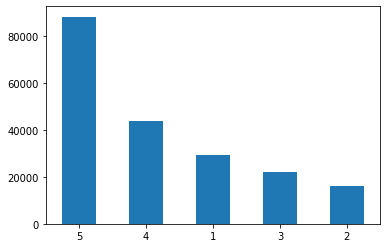

In [6]:
df['stars'].value_counts().plot(kind='bar', rot=0)

In [7]:
positive= df[df['stars']>3]

In [8]:
negative= df[df['stars']<3]

In [9]:
neutral= df[df['stars']==3]

#### Comments allocation into three categories

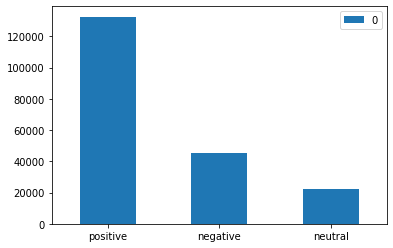

In [10]:
vals=[len(positive['stars']),len(negative['stars']),len(neutral['stars'])]
ind=['positive','negative', 'neutral']
pd.DataFrame(vals, index=ind).plot(kind='bar', rot=0)

### Selecting words that can identify positive and neutral comments
We want to avoid those words in negative comments analysis, because they can represent differnt types of comments
- number 500, available at the least in 20 docs and at the most in 99%. Features of one and two words are accepted
- applied lemmatization


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
def getUsedEverywhere(data1, data2):
    vectorizer2 = TfidfVectorizer(analyzer='word', tokenizer=LemmaTokenizer(), ngram_range=(1,2), min_df=20, max_df=0.99,max_features=300)
    X2 = vectorizer2.fit_transform(data1)
    featpos=vectorizer2.get_feature_names()
    X2 = vectorizer2.fit_transform(data2)
    featneu=vectorizer2.get_feature_names()

    for i in featpos:
        if not i in featneu:
            featneu.append(i)
    return featneu

def createBOW(data3,typ, words):
    if(typ==True):
        tfidfconverter = TfidfVectorizer(tokenizer=LemmaTokenizer(), max_features=500, min_df=5, max_df=0.9, ngram_range=(1,2),stop_words=words)  
    else:
        tfidfconverter = CountVectorizer(tokenizer=LemmaTokenizer(),analyzer='word', ngram_range=(1, 2), min_df=5, max_df=0.9,max_features=500, stop_words=words)
    X = tfidfconverter.fit_transform(data3)
    df = pd.DataFrame(X.toarray(), columns=tfidfconverter.get_feature_names())
    return df


### Creating BOW by using TF- IDF measurments
- lemmatization
- 500 fetuares
- ngrams: 1,2
- stopwords: presented in other neutral and negative comments( as well as english stopwords that have been removed earlier)


In [17]:
removeWords=getUsedEverywhere(positive['text'], neutral['text'])
bowtfidf=createBOW(negative['text'],True,removeWords)
#bowcount= createBOW(negative['text'],False,removeWords)

In [20]:
bowtfidf

,account,across,add,added,additional,ago,ahead,air,airport,along,...,worse,worst,wow,write,wrong,yelp,yes,yet,young,zero
count,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,...,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000,45396.000000
mean,0.002925,0.004920,0.005361,0.003539,0.003267,0.008411,0.003630,0.003261,0.003873,0.003572,...,0.007466,0.021496,0.004273,0.004759,0.013268,0.006684,0.006573,0.007259,0.004111,0.006141
std,0.033809,0.038596,0.041019,0.033664,0.030206,0.047724,0.033724,0.034363,0.041112,0.031636,...,0.050061,0.080613,0.038045,0.037320,0.060561,0.044959,0.041432,0.044001,0.036404,0.044926
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.932652,1.000000,1.000000,1.000000,0.745475,1.000000,1.000000,1.000000,1.000000,0.766442,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.864659,0.807342,1.000000,1.000000,1.000000


### Negaive comments have various topics( reason for the comments), lets try to see some general tendencies
- combine words that belongs to various topic and reduce the dimentions
- 15 topics to be chosen

In [22]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=15, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(bowtfidf)

In [25]:
do=pd.DataFrame(index=bowtfidf.columns)
count=0
ftrs=pd.DataFrame(index=range(1,10))
for i in lda.components_:
    
    d= pd.DataFrame(i,index=bowtfidf.columns,columns=[count])
    uu=pd.DataFrame(d.sort_values(by=[count],ascending=False).index[:10])
    ftrs[count]=uu
    do[count]=d
    count=count+1
      
ftrs

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,tip,rib,min,employee,suck,can,bowl,company,awful,game,mexican,bartender,wash,burnt,waste
2,cashier,onion,nail,delivery,salon,can not,cup,appointment,salty,son,chip,desk,oil,card,waste money
3,bill,bacon,seated,manager,disappointing,not,serve,phone,forever,loud,overpriced,pool,smell,disgusting,terrible
4,charged,wife,sat,closed,color,avoid,pasta,office,crab,cause,bean,ticket,cheap,soggy,worst
5,coupon,cook,walked,attitude,wont,sick,rating,month,decor,daughter,impressed,stay,floor,street,buy
6,manager,slice,finally,working,style,horrible,changed,doctor,salt,tiny,mediocre,bed,bathroom,credit,sale
7,charge,tomato,empty,counter,fix,mom,register,insurance,disappointment,watch,salsa,stayed,change,gone,save
8,massage,medium,party,pick,short,cost,remember,issue,hate,station,bbq,security,worker,across,bought
9,dollar,lettuce,hostess,phone,worse,picture,establishment,problem,ingredient,school,veggie,event,machine,credit card,somewhere


### Topics 3D Visualization with help of TSNE

In [35]:
from sklearn.manifold import TSNE
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
def visualize(do,columns):
    model = TSNE(n_components = 3, perplexity = 50)
    tsne_data = model.fit_transform(do)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(tsne_data)

    dataV=pd.DataFrame(x_scaled, columns=["D1","D2","D3"])

    for i in dataV:
        sd= 1*dataV[i].std()
        mean=dataV[i].mean()
    
        a=dataV[i].apply(lambda x:x if x> mean-sd  else mean-sd)
        dataV[i]=  a.apply(lambda x: x if  x< mean+sd  else mean+sd)
    fig = plt.figure(figsize=(30, 30))
    ax = fig.add_subplot(111, projection='3d')

    xs = dataV["D1"]
    ys = dataV["D2"]
    zs= dataV["D3"]
    ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

    ax.set_xlabel('D1')
    ax.set_ylabel('D2')
    ax.set_zlabel('D3')
    m=0
    for  x, y, z in zip( xs, ys, zs):
    
        label = columns[m]
        ax.text(x, y, z,  label)
        m=m+1


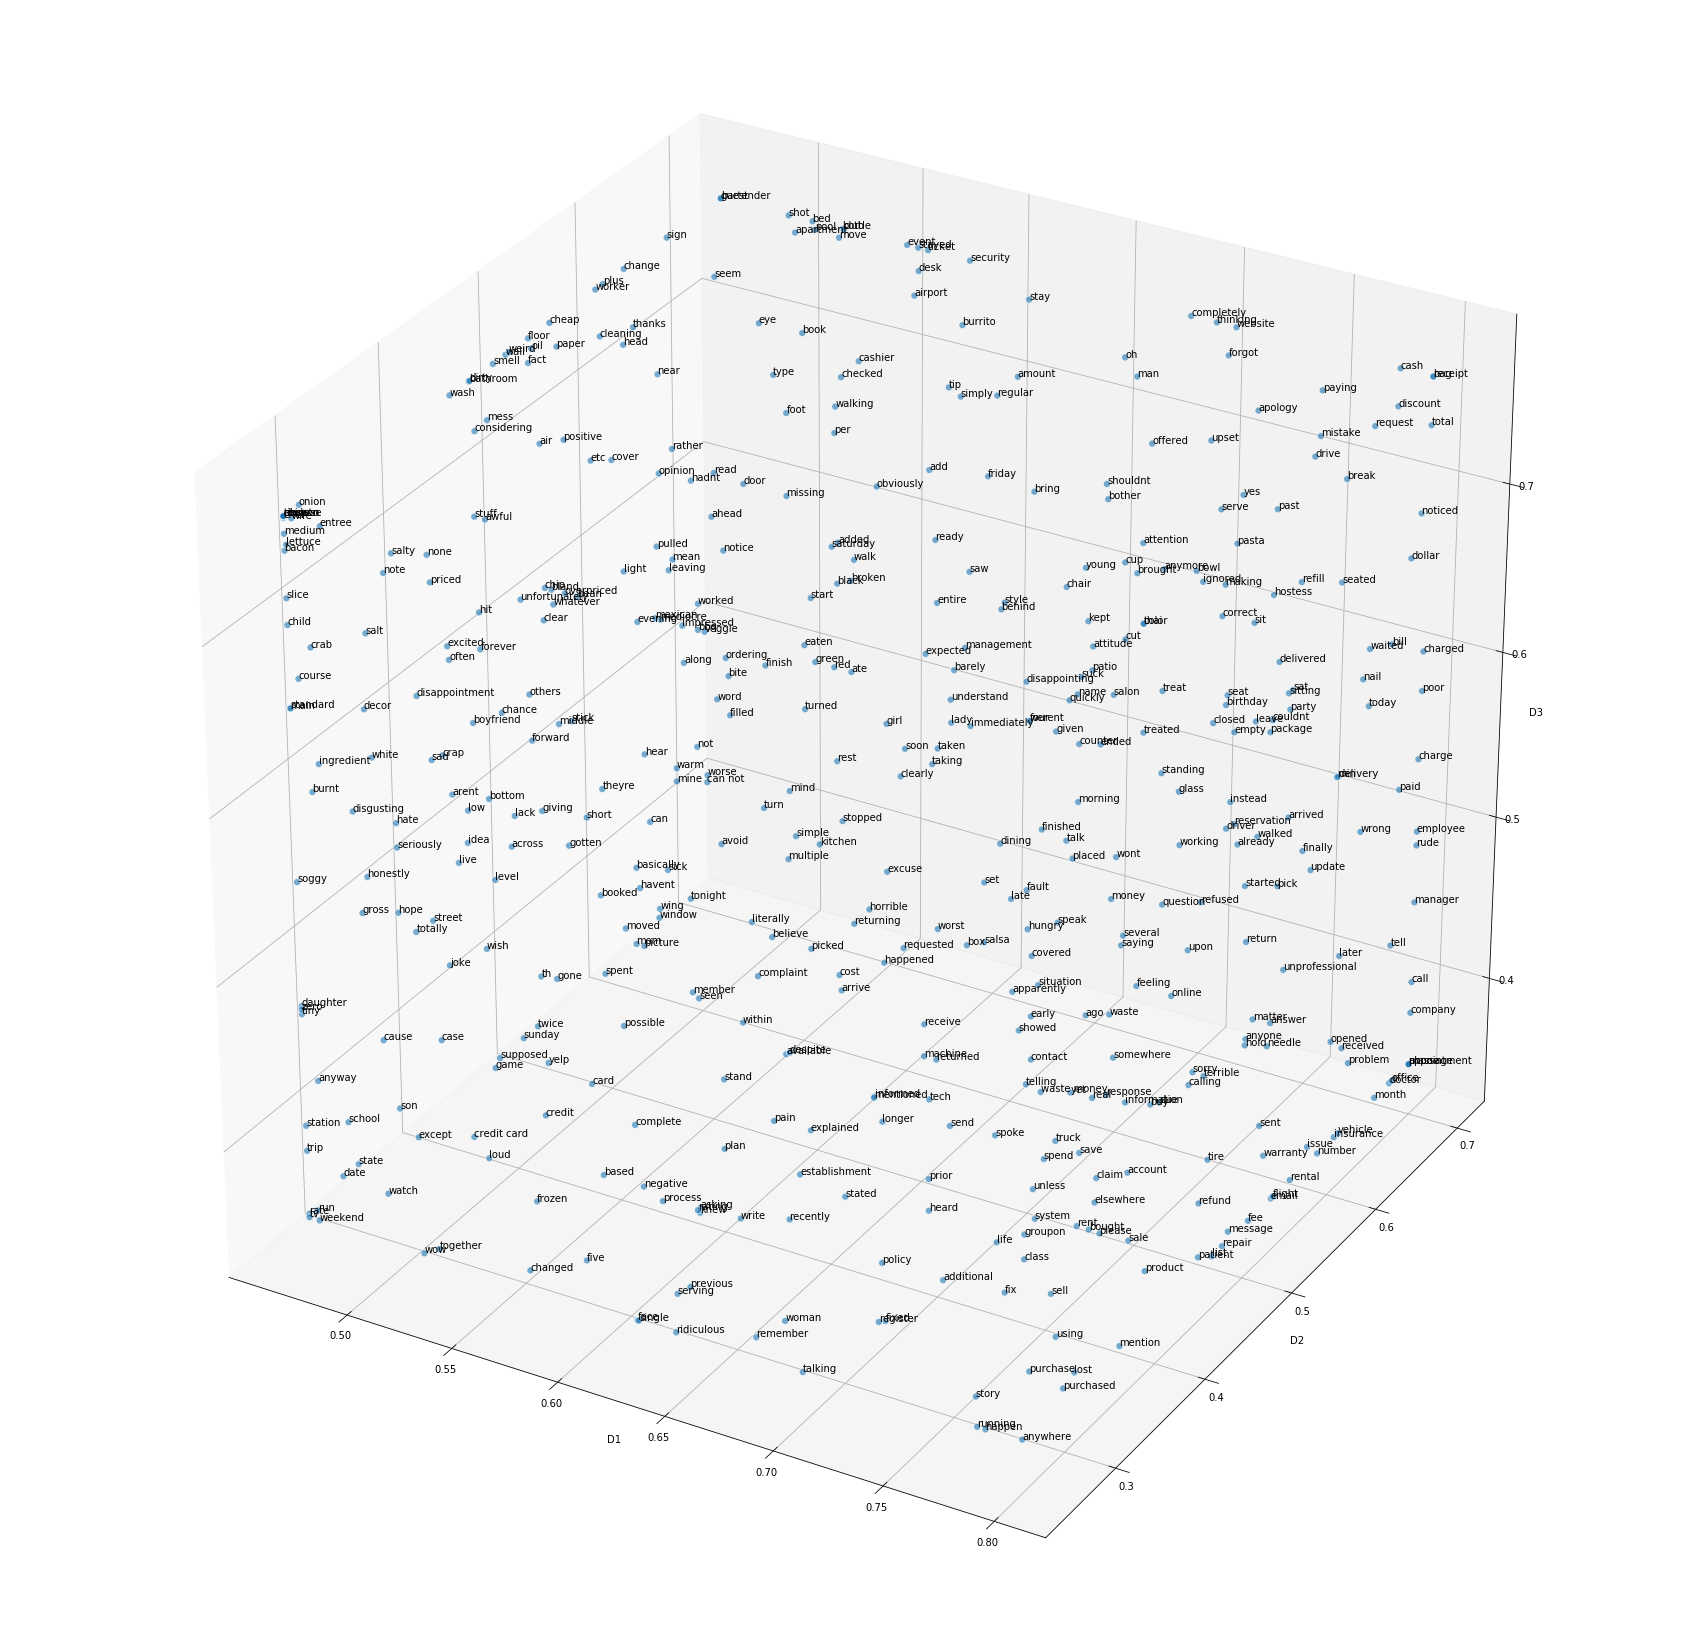

In [37]:
visualize(do,bowtfidf.columns)

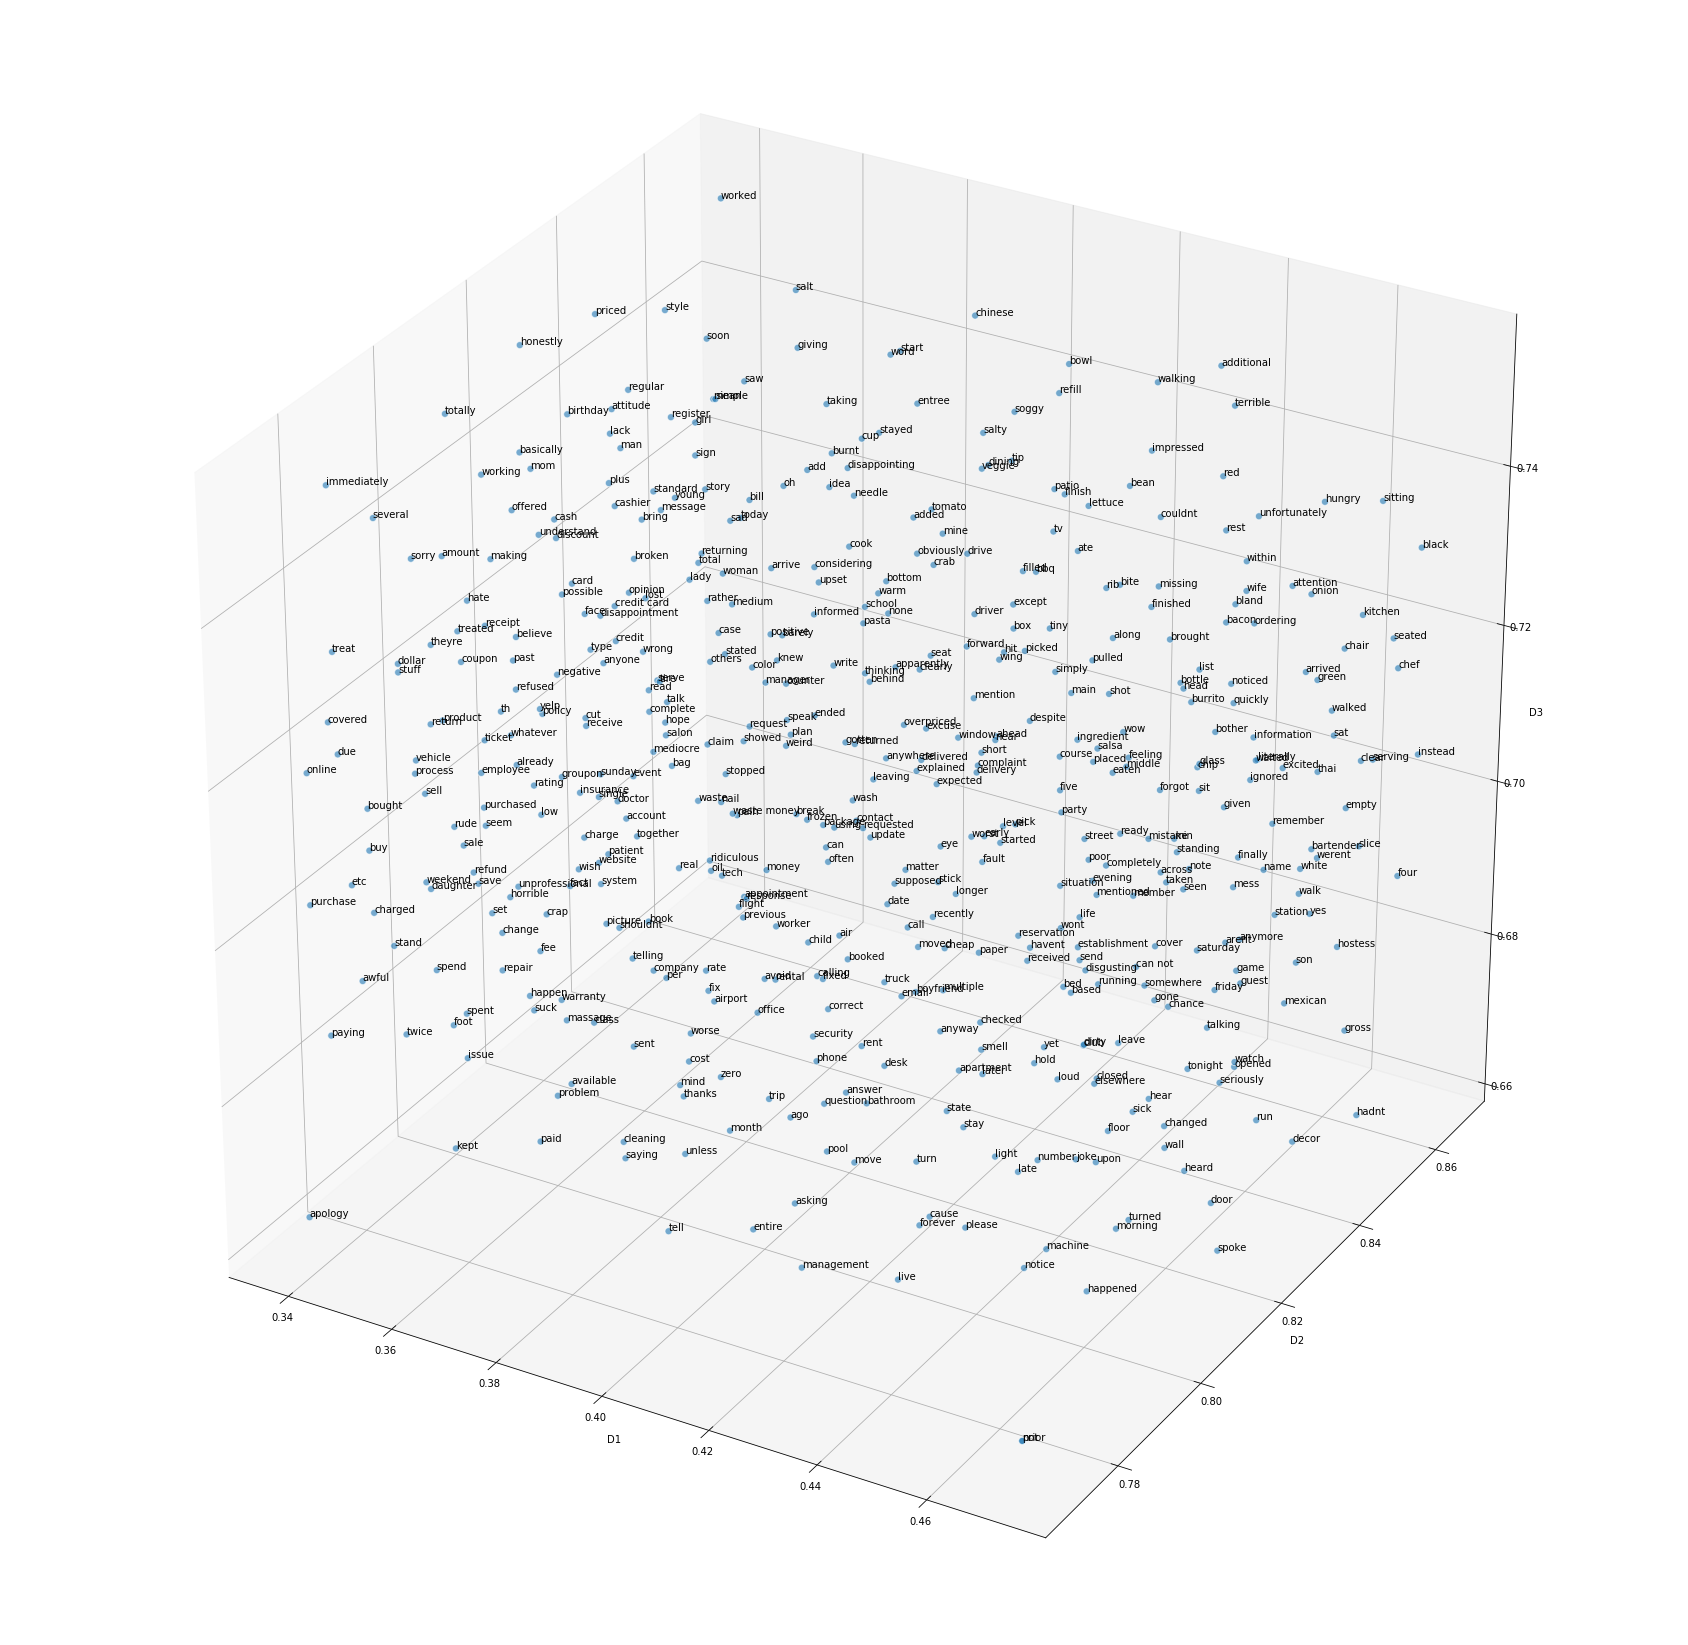

In [38]:
visualize(bowtfidf.T,bowtfidf.columns)

### BOW 3D Visualization with help of TSNE

In [32]:
dataV1['fetuares']=tfidfconverter.get_feature_names()
dataV1[['fetuares',"D1"]].sort_values(by="D1",ascending=False)[:10]


,fetuares,D1
300,please,0.676786
82,cleaning,0.676786
127,due,0.676786
311,problem,0.676786
121,doctor,0.676786
225,longer,0.676786
113,desk,0.676786
227,loud,0.676786
302,policy,0.676786
201,informed,0.676786


In [33]:
dataV1['fetuares']=tfidfconverter.get_feature_names()
dataV1[['fetuares',"D2"]].sort_values(by="D2",ascending=False)[:10]


,fetuares,D2
365,seated,0.734378
91,completely,0.734378
136,entree,0.734378
124,dress,0.734378
358,sat,0.734378
361,saw,0.734378
364,seat,0.734378
374,serving,0.734378
381,sign,0.734378
97,couldnt,0.734378


In [34]:
dataV1['fetuares']=tfidfconverter.get_feature_names()
dataV1[['fetuares',"D3"]].sort_values(by="D3",ascending=False)[:10]


,fetuares,D3
499,zero,0.544312
363,school,0.544312
220,light,0.544312
375,set,0.544312
96,cost,0.544312
204,insurance,0.544312
202,ingredient,0.544312
49,bought,0.544312
380,sick,0.544312
192,hope,0.544312


## Photos classification
The dataset contains the following labels

In [39]:
photosData= pd.read_json("photo.json", lines=True)

In [42]:
m=photosData['label'].value_counts()
m

food       114874
inside      52448
drink       18121
outside     11534
menu         3023
Name: label, dtype: int64

### Available Photos

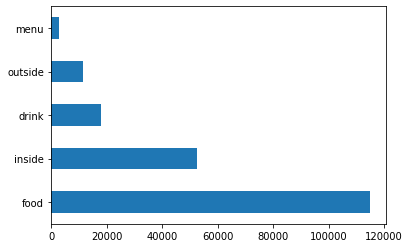

In [43]:
m.plot(kind="barh")

### Sorting photos into corresponding folders

In [33]:
import shutil
for i, row in photosData.iterrows():
    label= row['label']
    id=row['photo_id']
    if os.path.isfile("yelp_photos/photos/"+id+".jpg"):
        os.rename("yelp_photos/photos/"+id+".jpg", "yelp_photos/"+label+"/"+id+".jpg")

In [298]:

def getFeatures(path,sampleSize):
    allFeatures=[]
    hh=0
    for filename in os.listdir(path):
        img = cv2.imread(path+filename)
        img1 = cv2.resize(img, (240,240), interpolation = cv2.INTER_AREA)
        mask = nm.zeros(img1.shape[:2],nm.uint8)
        bgdModel = nm.zeros((1,65),nm.float64)
        fgdModel = nm.zeros((1,65),nm.float64)
        rect = (5,5,235,235)
        cv2.grabCut(img1,mask,rect,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_RECT)
        mask2 = nm.where((mask==2)|(mask==0),0,1).astype('uint8')
        img1 = img1*mask2[:,:,nm.newaxis]
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        #img1= cv2.GaussianBlur(img1,(5,5),cv2.BORDER_DEFAULT)
        ll=cv2.equalizeHist(img1)
        orb = cv2.ORB_create(nfeatures=100)
        keypoints, descriptors = orb.detectAndCompute(ll, None)
        allFeatures.append(descriptors)#array[ImageNb][FeatureNb]
        hh=hh+1
        if(hh==sampleSize):
            return allFeatures
    
    

    

In [300]:
def runKmeans(allFeatures):
    kmeans = KMeans(n_clusters = 200, n_init=10)
    gg=[item for sublist in allFeatures for item in sublist]
    kmeans.fit(gg)#vocabulary
    #visual_words = kmeans.cluster_centers_
    return kmeans

In [304]:

def calcTf(kmeans, allFeatures):
    alla=[]
    for i in allFeatures:
        clusters=[]
        for u in i:
            cluster=kmeans.predict([u])  
            clusters.append(cluster[0])
        
        nums=pd.Series(clusters).value_counts()
        tf=nums.apply(lambda a:a/nums.sum())
        alla.append(tf.to_dict())
#tf for each feature in the document
    return alla

def calcDocsPerFeature(alla,clusters):
    documentsPerFeature=[0] * clusters
    for i in alla:
        for k in i:
            documentsPerFeature[k-1]=documentsPerFeature[k-1]+1
#number of documents containing the feature
    return documentsPerFeature

def calcTfIdf(alla,documentsPerFeature):
    fr= pd.DataFrame(columns= range(1,201))
    for i in alla:
        row=[0]*200
        totalWords=0
        for k in i:
            idf=m.log(len(alla)/documentsPerFeature[k-1])
            res=i[k]*idf
            row[k]=res
        fr=fr.append(pd.Series(row, range(1,201)),ignore_index=True )  
    return fr   

### Image preprocessing
- background removal
- noise removal
- histogram equalization
- resize to 240x240

### Extracting features from n images with help of ORB
- sample of 200 photos
- each photo gets up to 100 features

In [320]:
allFeatures=getFeatures('yelp_photos/food/',200)


### Clustering into n clusters
- 200 clusters

In [321]:
kmeans=runKmeans(allFeatures)

### Calculating TF IDF and creating BOW

In [318]:
alla=calcTf(kmeans, allFeatures)
documentsPerFeature=calcDocsPerFeature(alla,200)
calcTfIdf(alla,documentsPerFeature)

,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.012122,0.000000,0.000000,0.000000,0.013542,0.000000
2,0.011238,0.000000,0.010217,0.009808,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.012895,0.000000,0.000000,0.013260,0.012200
3,0.011356,0.000000,0.000000,0.009912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.035982,0.013030,0.012160,0.027565,0.000000,0.000000
4,0.000000,0.013400,0.000000,0.019823,0.000000,0.012499,0.013030,0.013589,0.015702,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.013782,0.026799,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026338,0.027468,0.000000,0.013542,...,0.011794,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
196,0.011238,0.000000,0.020434,0.009808,0.013076,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.012541,0.0,0.023738,0.000000,0.024066,0.000000,0.013260,0.000000
197,0.011477,0.013542,0.010434,0.000000,0.000000,0.012632,0.000000,0.041202,0.000000,0.013542,...,0.000000,0.0,0.000000,0.0,0.000000,0.013169,0.000000,0.000000,0.000000,0.000000
198,0.000000,0.000000,0.000000,0.000000,0.040492,0.025536,0.013310,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.012593


### Visualizing fetuares in 3D dimention scatter plot

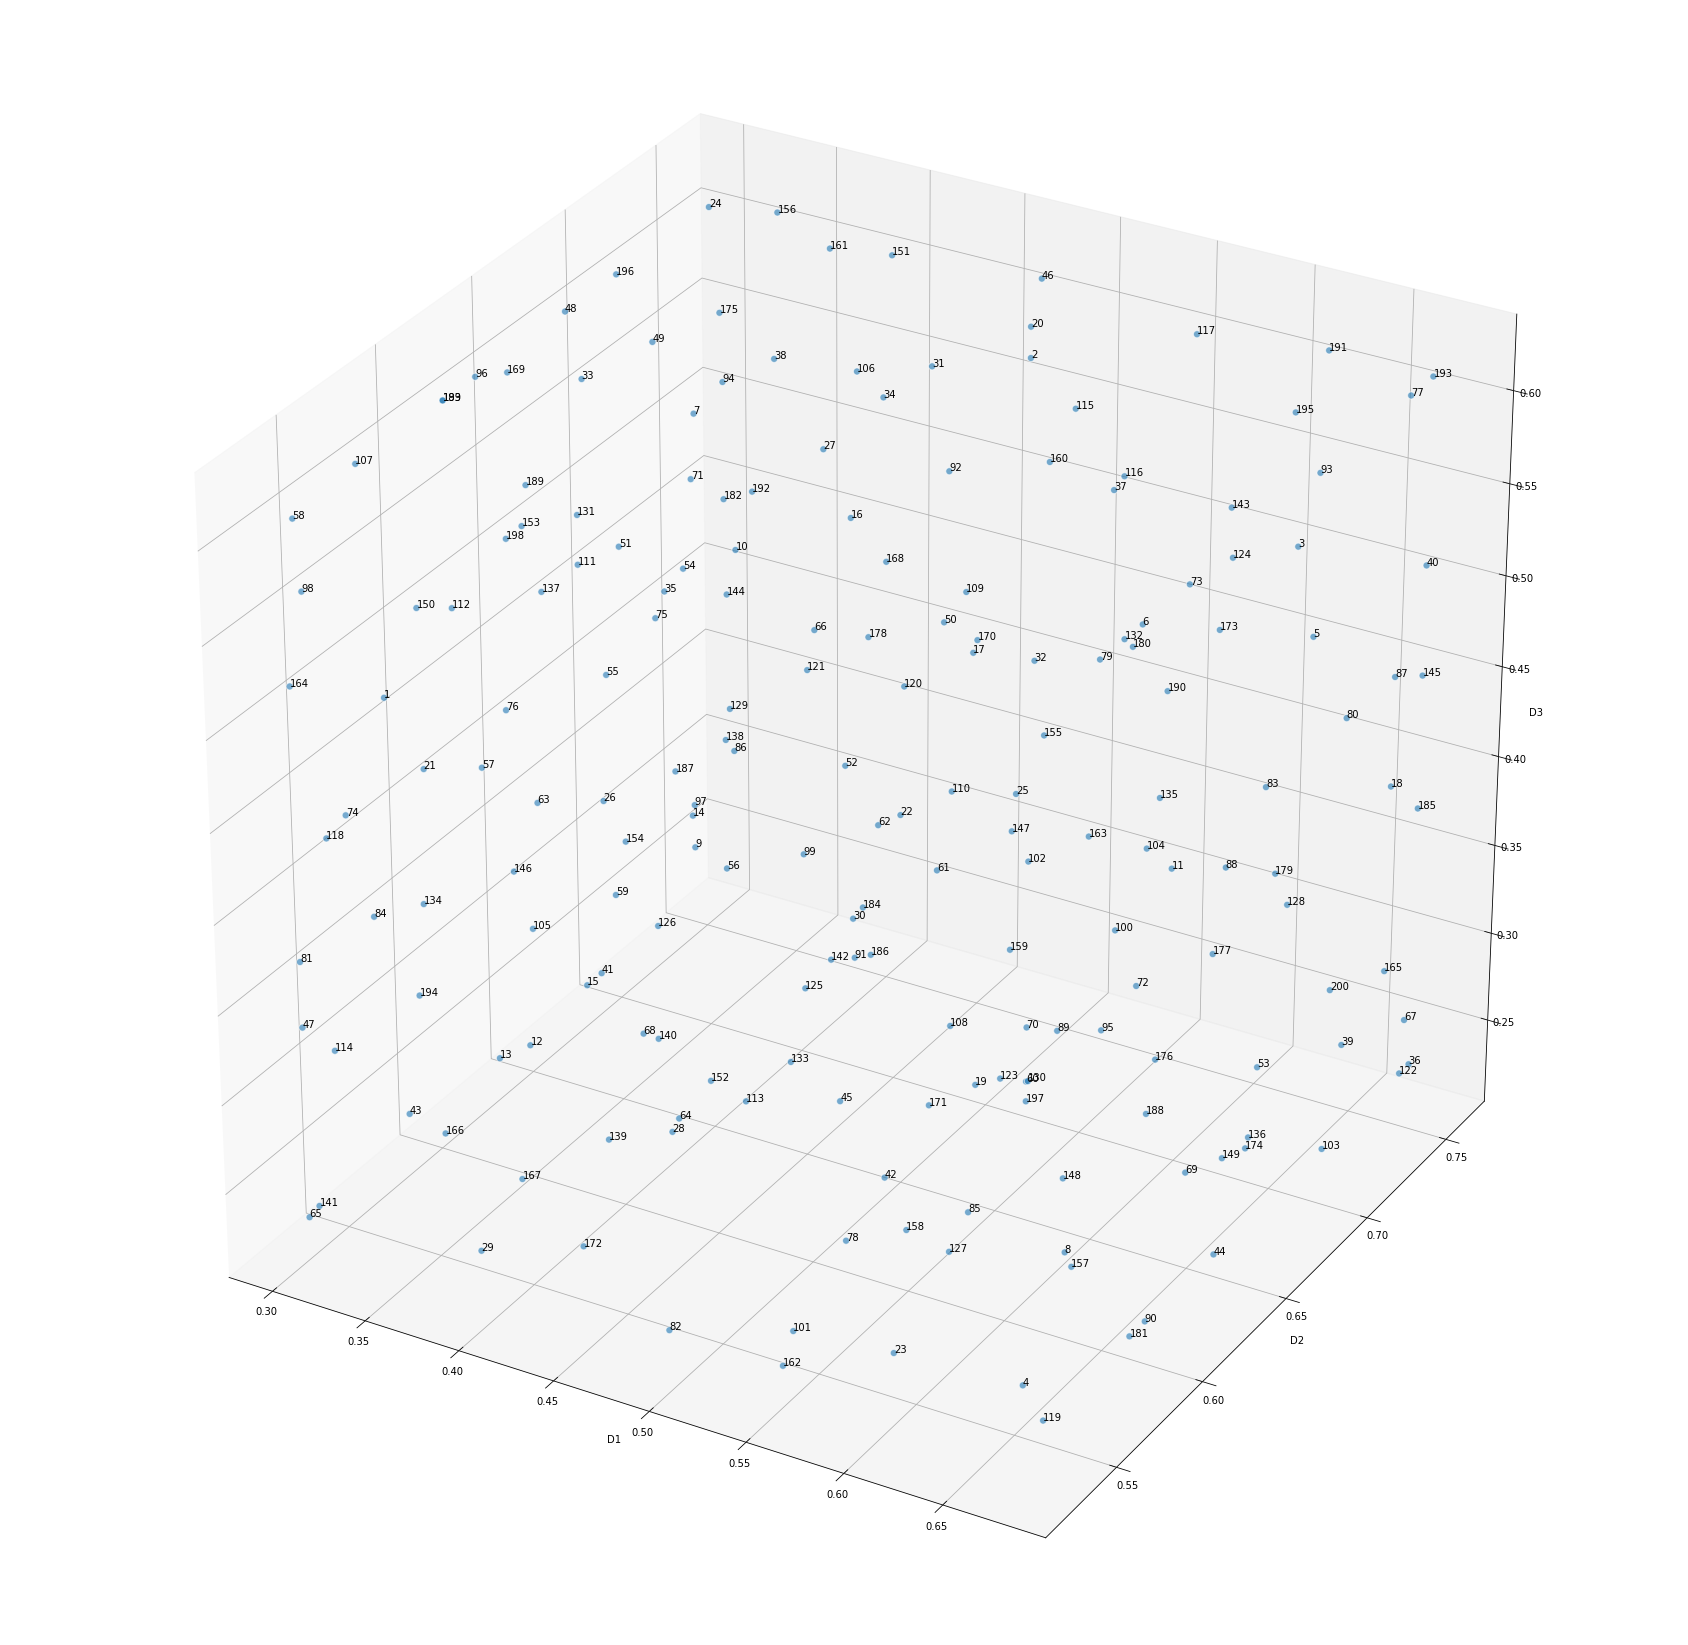

In [319]:
visualize(fr.T,fr.columns)

In [115]:
'''
y1=int(keypoints[0].pt[1]+keypoints[0].size/2)
y2=int(keypoints[0].pt[1]-keypoints[0].size/2)
x1= int(keypoints[0].pt[0]+keypoints[0].size/2)
x2=int(keypoints[0].pt[0]-keypoints[0].size/2)
crop_img = wholeImage[y2:y1,x2:x1]
cv2.imshow("cropped", crop_img)
cv2.waitKey(0)
'''

91
60
2189
2158


## YELP API Data Extraction
- get reviews, sorted by rating, business located in Deli
- apply filter:rating <3 
- save in the corresponding file

In [16]:
import json
import requests
import csv

key='crsZaDRn86h5i2YZhSlC4XdB_vunuNAQzIbUIH_wf_zN5OugkI116aSvccoHMLN5DPVb1RJYwWJUq1ns4SbjmiTFmZVmJkl5wegiKt3qS-2YsOLUFevIv8cGdmhVXnYx'
headers = {
    'Authorization': 'Bearer '+key,
    'Content-Type': 'application/graphql',
}

data = '{search(sort_by:"reviews",location:"moscow, deli, newyork, istambul") {business { reviews{rating text} }}}'

response = requests.post('https://api.yelp.com/v3/graphql', headers=headers, data=data)

json_obj = json.loads(response.content)
json_obj



arr=[]

for i in json_obj['data']['search']['business']:
    for u in i['reviews']:
        if(len(u)>0 and u['rating']<3):
            arr.append({'rating':u['rating'],'text':u['text']})


pd.DataFrame(arr).to_csv('data.csv', mode='a', header=False)
arr

[{'rating': 1,
  'text': 'This breaks my heart because I grew up eating here with my family. After many years we decided to go to El Malecon last night. Literally the worst...'},
 {'rating': 2,
  'text': 'Used to be my favorite restaurant in my neighborhood.\nToday after a long week I came to enjoy some brunch and mimosas - was really looking forward to it....'},
 {'rating': 2,
  'text': 'Not a very wide selection of foods to choose from. Had the signature burger and it was nothing to to rave about. The meat was on the tough side, which could...'},
 {'rating': 1,
  'text': 'Let me start off by stating this is a review for "the experiment" sandwich only and I opted to get it cold. \n\nFirst off, this sandwich is $13 so one would...'},
 {'rating': 1,
  'text': "Been here for brunch a few times but after the most recent visit, it will be my last. The drinks are fine, but the food isn't. There has been an issue with..."},
 {'rating': 1,
  'text': "Probably the worst dining experience I've 